# KF - Object Tracking Demo - JAX

In this demo, we will be looking at how we can do object tracking via the Kalman Filter (KF).

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))



In [2]:
import jax
import jax.numpy as jnp
from jax import random
from functools import partial
import matplotlib.pyplot as plt
from jaxkf._src.kf import KalmanFilter
from jaxkf._src.viz import plot_tracking_values
from jaxkf._src.utils import calculate_error_bounds


%load_ext autoreload
%autoreload 2

## System

### State Transition Dynamics

We assume that we can fully describe the state when we have the `(x,y)` coordinates of the position and the `(x,y)` velocity. So we can write this as:

$$
\mathbf{z}_t = 
\begin{bmatrix}
z_t^1 \\ z_t^2 \\ \dot{z}_t^1 \\ \dot{z}_t^2
\end{bmatrix}
$$

where $z_t^d$ is the coordinate of the position and $\dot{z}^d$ is the velocity. 

We can describe the dynamics of the system using the following system of equations:

$$
\begin{aligned}
z_t^1 &= z_{t-1}^1 + \Delta_t \dot{z}_t^1 + \epsilon_t^1 \\
z_t^2 &= z_{t-1}^2 + \Delta_t \dot{z}_t^2 + \epsilon_t^2 \\
\dot{z}_t^1 &= \dot{z}_{t-1}^1 + \epsilon_t^3 \\
\dot{z}_t^2 &= \dot{z}_{t-1}^2 + \epsilon_t^4 \\
\end{aligned}
$$

This is a very simple formulation which takes a first order approximation to the change in position based on speed and we also assume constant velocity. Note, we also include some noise because we assume that some of the dynamics are noisy, i.e. there are random acceleration and position changes in the model. 


We can also put this into matrix formulation like so:

$$
\mathbf{z}_t = \mathbf{A}_t \mathbf{z}_{t-1} + \boldsymbol{\epsilon}_t
$$

where:

$$
\mathbf{A}_t = 
\begin{bmatrix}
1 & 0 & \Delta_t & 0 \\
0 & 1 & 0 & \Delta_t \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}, \;\; \mathbf{A}_t \in \mathbb{R}^{4\times 4}
$$

---
### Emissions Model

We can only fully observe the locations (not the velocities). So this will be a lower dimensional vector of size 2-D. The system of equations are as follows:

$$
\begin{aligned}
x_t^1 &= z_t^1 + \delta_t^1 \\
x_t^2 &= z_t^2 + \delta_t^2 \\
\end{aligned}
$$

This is a very simple model where we assume we can extract the direct positions (plus some noise) from the state.

We can write this in an abbreviated matrix formulation:

$$
\mathbf{x}_t = \mathbf{C}_t \mathbf{z}_t + \delta_t
$$

where:

$$
\mathbf{C}_t = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
\end{bmatrix}, \;\; \mathbf{C}_t \in \mathbb{R}^{2 \times 4}
$$


In [3]:
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

key = random.PRNGKey(314)
timesteps = 15
Δt = 10.0
A = jnp.array([
    [1, 0, Δt, 0],
    [0, 1, 0, Δt],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

C = jnp.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

state_size, _ = A.shape
observation_size, _ = C.shape

Q = jnp.eye(state_size) * 0.001
R = jnp.eye(observation_size) * 1.0
# Prior parameter distribution
mu0 = jnp.array([8, 10, 1, 0]).astype(float)
Sigma0 = jnp.eye(state_size) * 1.0


## Model

In [4]:
kf_model = KalmanFilter(
    A, C, 
    Q, R, 
    mu0, Sigma0, 
    timesteps
)

## Example - Single Trajectory

## Observations

In [5]:
%%time
n_samples = 1
sample_initial_state = False

key = random.PRNGKey(1233)
state_samples, obs_samples = kf_model.sample(
    key=key, 
    n_samples=n_samples, 
    sample_intial_state=sample_initial_state
)



CPU times: user 927 ms, sys: 40.7 ms, total: 967 ms
Wall time: 971 ms


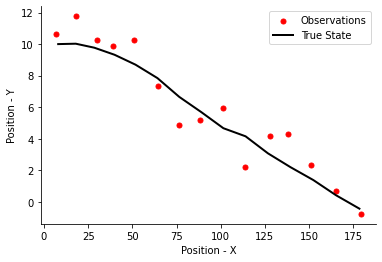

In [6]:
fig, ax = plt.subplots()

# plot the observations
ax.scatter(obs_samples[..., 0], obs_samples[..., 1], marker=".", s=100, color="red", label="Observations")

# plot the estimated states
ax.plot(state_samples[..., 0], state_samples[..., 1], "k-", linewidth=2, label="True State")

ax.set(xlabel="Position - X", ylabel="Position - Y")

plt.legend()
plt.show()

### Forward Pass (Filtering)

In [7]:
%%time

mus, sigmas, mus_cond, sigmas_cond = kf_model.filter(obs_samples)

mus.shape, mus_cond.shape

CPU times: user 600 ms, sys: 111 ms, total: 711 ms
Wall time: 373 ms


((15, 4), (15, 4))

In [8]:
pred_var = jnp.diagonal(sigmas, axis1=1, axis2=2)
pred_var.shape

(15, 4)

In [9]:
lb, ub = calculate_error_bounds(mus, pred_var, 1.96)

### Viz

#### Filtered Dist

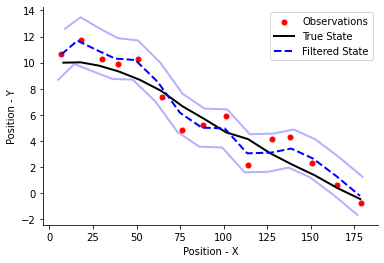

In [10]:
fig, ax = plt.subplots()

# plot the observations
ax.scatter(obs_samples[..., 0], obs_samples[..., 1], marker=".", s=100, color="red", label="Observations")

# plot the estimated states
ax.plot(state_samples[..., 0], state_samples[..., 1], "k-", linewidth=2, label="True State")

# plot the filtered dist
ax.plot(mus[..., 0], mus[..., 1], linestyle="--", color="blue", linewidth=2, label="Filtered State")
ax.plot(lb[...,0], lb[..., 1], linestyle="-", color="blue", linewidth=2, alpha=0.3)
ax.plot(ub[...,0], ub[...,1], linestyle="-", color="blue", linewidth=2, alpha=0.3)

ax.set(xlabel="Position - X", ylabel="Position - Y")

plt.legend()
plt.show()

### Backward Pass (Smoothing)

In [11]:
%%time

mus_smooth, sigmas_smooth = kf_model.smooth(mus, sigmas, mus_cond, sigmas_cond)

CPU times: user 845 ms, sys: 197 ms, total: 1.04 s
Wall time: 686 ms


In [12]:
pred_var = jnp.diagonal(sigmas_smooth, axis1=1, axis2=2)
pred_var.shape

(15, 4)

In [13]:
lb, ub = calculate_error_bounds(mus_smooth, pred_var, 1.96)

### Visualization

#### Smoothed Distribution

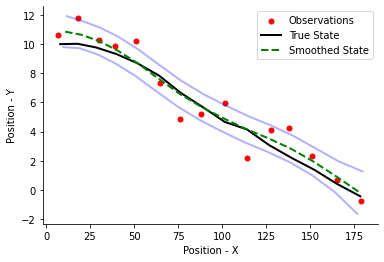

In [14]:
fig, ax = plt.subplots()

# plot the observations
ax.scatter(obs_samples[..., 0], obs_samples[..., 1], marker=".", s=100, color="red", label="Observations")

# plot the estimated states
ax.plot(state_samples[..., 0], state_samples[..., 1], "k-", linewidth=2, label="True State")

# plot the filtered dist
ax.plot(mus_smooth[..., 0], mus_smooth[..., 1], linestyle="--", color="green", linewidth=2, label="Smoothed State")
ax.plot(lb[...,0], lb[..., 1], linestyle="-", color="blue", linewidth=2, alpha=0.3)
ax.plot(ub[...,0], ub[...,1], linestyle="-", color="blue", linewidth=2, alpha=0.3)


ax.set(xlabel="Position - X", ylabel="Position - Y")

plt.legend()
plt.show()

#### Tracking - Original

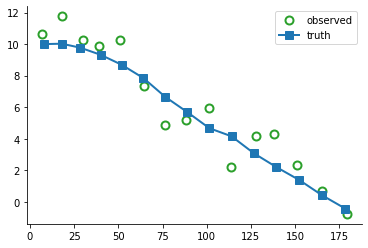

In [15]:
fig, axs = plt.subplots()
axs.plot(
    obs_samples[:, 0], obs_samples[:, 1], 
    marker="o", linewidth=0,
     markerfacecolor="none", markeredgewidth=2, markersize=8, label="observed", c="tab:green")
axs.plot(
    state_samples[:, 0], state_samples[:, 1], 
    linewidth=2, label="truth", marker="s", markersize=8)
axs.legend()
# axs.axis("equal")
# pml.savefig("kalman_tracking_truth.png")
plt.show()

#### Tracking - Filtered

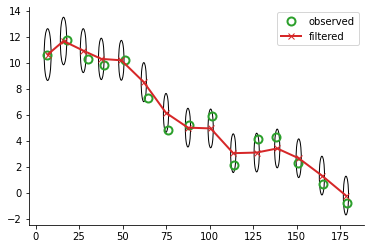

In [16]:
fig, axs = plt.subplots()
axs = plot_tracking_values(obs_samples, mus, sigmas, "filtered", axs)
# pml.savefig("kalman_tracking_filtered.png")
plt.show()

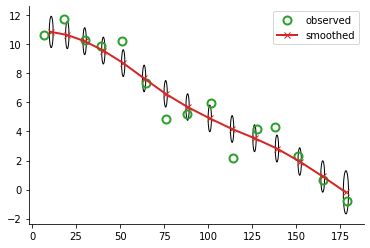

In [17]:
fig, axs = plt.subplots()
axs = plot_tracking_values(obs_samples, mus_smooth, sigmas_smooth, "smoothed", axs)
# pml.savefig("kalman_tracking_smoothed.png")
plt.show()

### Losses

In [18]:
l2_filter = jnp.linalg.norm(state_samples[:, :2] - mus[:, :2], 2)
l2_smooth = jnp.linalg.norm(state_samples[:, :2] - mus_smooth[:, :2], 2)

print(f"L2-filter: {l2_filter:0.4f}")
print(f"L2-smooth: {l2_smooth:0.4f}")

L2-filter: 6.0608
L2-smooth: 4.2104


## Example - Multiple Trajectories

### Draw Samples

In [19]:
%%time
n_samples = 5
sample_initial_state = False

key = random.PRNGKey(123)
state_samples, obs_samples = kf_model.sample(
    key=key, 
    n_samples=n_samples, 
    sample_intial_state=sample_initial_state
)



CPU times: user 955 ms, sys: 38.9 ms, total: 994 ms
Wall time: 1.06 s


In [20]:
state_samples.shape, obs_samples.shape

((5, 15, 4), (5, 15, 2))

#### Viz - Different Trajectories

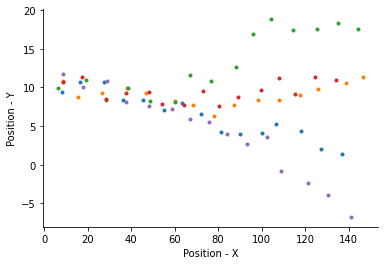

In [21]:
fig, ax = plt.subplots()

ax.plot(obs_samples[..., 0].T, obs_samples[..., 1].T, ".")

ax.set(xlabel="Position - X", ylabel="Position - Y")
plt.show()

### Forward Filter

In [22]:
%%time

mus, sigmas, mus_cond, sigmas_cond = kf_model.filter(obs_samples)

mus.shape, mus_cond.shape

CPU times: user 582 ms, sys: 176 ms, total: 758 ms
Wall time: 409 ms


((5, 15, 4), (5, 15, 4))

#### Viz - Filtered Dist

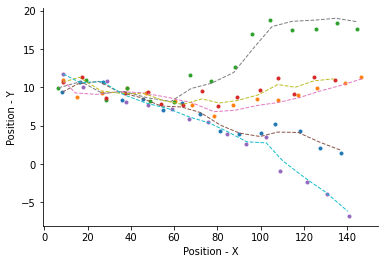

In [23]:
fig, ax = plt.subplots()

# plot samples
ax.plot(obs_samples[..., 0].T, obs_samples[..., 1].T, ".", label="Samples")

# plot filtered
# ax.plot(mus[..., 0].T, mus[..., 1].T, "--", linewidth=3, label="Filtered")
ax.plot(mus[..., 0].T, mus[..., 1].T, "--", linewidth=1, label="Filtered")

ax.set(xlabel="Position - X", ylabel="Position - Y")
plt.show()

#### Viz - Filtered (Conditioned)

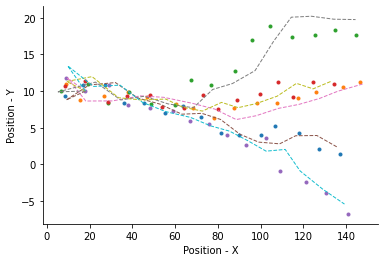

In [24]:
fig, ax = plt.subplots()

# plot samples
ax.plot(obs_samples[..., 0].T, obs_samples[..., 1].T, ".", label="Samples")

# plot filtered
# ax.plot(mus[..., 0].T, mus[..., 1].T, "--", linewidth=3, label="Filtered")
ax.plot(mus_cond[..., 0].T, mus_cond[..., 1].T, "--", linewidth=1, label="Filtered")

ax.set(xlabel="Position - X", ylabel="Position - Y")
plt.show()

### Backwards Filter

In [25]:
%%time

mus_smooth, sigmas_smooth = kf_model.smooth(mus, sigmas, mus_cond, sigmas_cond)

CPU times: user 1.09 s, sys: 198 ms, total: 1.29 s
Wall time: 914 ms


#### Viz - Smoothed

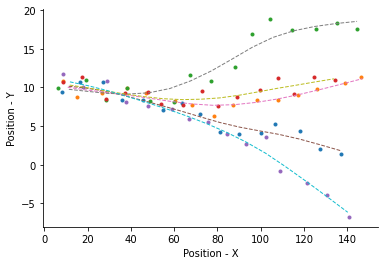

In [26]:
fig, ax = plt.subplots()

# plot samples
ax.plot(obs_samples[..., 0].T, obs_samples[..., 1].T, ".", label="Samples")

# plot smooth
ax.plot(mus_smooth[..., 0].T, mus_smooth[..., 1].T, "--", linewidth=1, label="Smoothed")

ax.set(xlabel="Position - X", ylabel="Position - Y")
plt.show()

#### Viz - Smoothed & Filtered

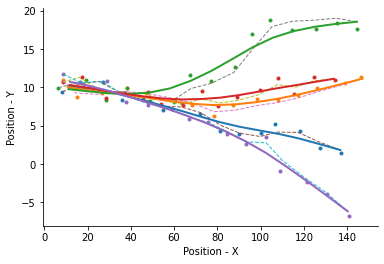

In [27]:
fig, ax = plt.subplots()

# plot samples
ax.plot(obs_samples[..., 0].T, obs_samples[..., 1].T, ".", label="Samples")

# plot filtered
ax.plot(mus[..., 0].T, mus[..., 1].T, "--", linewidth=1, label="Filtered")

# plot smoothed
ax.plot(mus_smooth[..., 0].T, mus_smooth[..., 1].T, "-", linewidth=2, label="Smoothed")

ax.set(xlabel="Position - X", ylabel="Position - Y")
plt.show()

### Losses

In [28]:
fn = lambda x, y: jnp.linalg.norm(x-y, ord=2)

In [29]:
# calculate for each sample
l2_filter = jax.vmap(fn, in_axes=(0, 0))(state_samples[..., :2], mus[..., :2])
l2_smooth = jax.vmap(fn, in_axes=(0, 0))(state_samples[..., :2], mus_smooth[..., :2])

In [30]:
print(f"L2-filter: {l2_filter.mean():0.4f}")
print(f"L2-smooth: {l2_smooth.mean():0.4f}")

L2-filter: 4.6460
L2-smooth: 4.2790
